# Advanced Simulation

## Imports
Importing required libraries (also applying future annotations for Python 3.8), and installing required libraries.

In [4]:
!pip install multiprocess tqdm numpy pandas matplotlib

In [2]:
from __future__ import annotations
from typing import Any, Optional
from re import findall, sub

# import multiprocessing
import multiprocess
import pickle
import time
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm

## Set constants
Set ```CURRENT_TIME``` to detect the current time, set ```FLOORS``` to set the number of floors in the building.

In [35]:
# Set current time
CURRENT_TIME: float = 0.0

# Set current strategy
CURRENT_STRATEGY = "top_floor_rest"


# Set constants
FLOORS = 6
DWELL_TIME = 10.0
MAX_RUNTIME = 86400
ELEVATOR_TRAVEL_TIME = 8.0
MAX_ELEVATOR_CAPACITY = 10

# DWELL_TIME_SIMULATION_RANGE = range(1, 21)
SIMULATION_ITERATIONS = 100

GEOMETRIC_ARRIVAL_PROBABILITY = 0.667

# Gives base rate (Poisson arrivals per hour)
BASE_ARRIVALS = np.array([
    [0, 8, 8, 8, 8, 8],
    [8, 0, 1, 1, 1, 1],
    [8, 1, 0, 1, 1, 1],
    [8, 1, 1, 0, 1, 1],
    [8, 1, 1, 1, 0, 1],
    [8, 1, 1, 1, 1, 0]
])

### Set ratio
This sets the ratio at time $t$ for the base arrival.

,arrival,departure,inter
0,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000
...,...,...,...
1435,0.857571,0.774168,0.781015
1436,0.849605,0.767177,0.774095
1437,0.841622,0.760161,0.767143
1438,0.833625,0.753122,0.760162


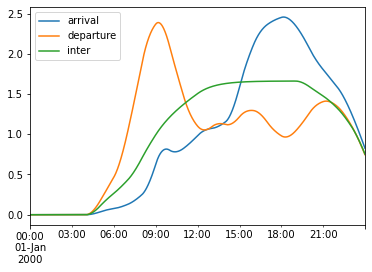

In [3]:
# The ratio per hour
HOURLY_RATIO = pd.DataFrame({
    #                       00    01   02   03  04    05   06   07   08   09   10   11   12   13   14   15   16  17   18   19   20   21   22   23   24
    "arrival":   np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.1, 0.2, 0.4, 1.2, 0.6, 0.9, 1.1, 1.0, 1.2, 2.2, 2.4, 2.3, 2.3, 1.9, 1.5, 1.4, 1.2, 0.7, 0.2]),
    "departure": np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.8, 1.9, 2.8, 2.5, 1.2, 0.7, 0.8, 1.2, 1.0, 1.4, 1.2, 0.8, 0.8, 1.2, 1.5, 1.4, 1.1, 0.7, 0.2]),
    "inter":     np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.3, 0.4, 0.6, 1.0, 1.2, 1.3, 1.4, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.3, 1.2, 1.0, 0.7, 0.2])
}, index=pd.date_range("2000", freq="H", periods=25)).resample("1min").interpolate().ewm(span=150).mean()
HOURLY_RATIO = HOURLY_RATIO[:-1]
HOURLY_RATIO /= HOURLY_RATIO.mean()
HOURLY_RATIO.plot()
new_index = (HOURLY_RATIO.index.hour * 60 + HOURLY_RATIO.index.minute)
HOURLY_RATIO = HOURLY_RATIO.set_index(new_index)
HOURLY_RATIO

## Create State
Create a state class that keeps track of the current state. The state contains the current direction of the elevator (```False``` for down, ```True``` for up), the current floor, the state of the door (```False``` for closed, ```True``` for open), a matrix of people who are waiting and a vector that keeps track of people waiting in the elevator.

In [37]:
class State:
    direction: bool
    current_floor: int
    door: bool
    waiting: np.ndarray
    elevator: np.ndarray
    rest: bool # Nieuwe om de lift niets te laten doen als er niemand is

    def __init__(self):
        self.direction = False # True: up, False: down
        self.current_floor = FLOORS - 1 # Start at top floor
        self.door = False # True: open, False: closed
        self.waiting = np.zeros((FLOORS, FLOORS), np.int_)
        self.elevator = np.zeros(FLOORS, np.int_)
        self.rest = True

    def copy(self) -> State:
        new_state = State()
        new_state.direction = self.direction
        new_state.current_floor = self.current_floor
        new_state.door = self.door
        new_state.waiting = self.waiting.copy()
        new_state.elevator = self.elevator.copy()
        new_state.rest = self.rest
        return new_state

    def to_dict(self) -> dict:
        d = {}
        d["direction"] = self.direction
        d["current_floor"] = self.current_floor
        d["door"] = self.door
        d["waiting"] = self.waiting.copy()
        d["elevator"] = self.elevator.copy()
        d["rest"] = self.rest

        return d

    def __str__(self) -> str:
        return f"\n{{ direction: {self.direction}, current_floor: {self.current_floor}, door: {self.door}, waiting: {self.waiting}, elevator: {self.elevator}, rest: {self.rest} }}"

    def __repr__(self) -> str:
        return self.__str__()

example_state = State()

## Get active events
This function returns a set of events that are currently active. It always returns the arrival events, if the door is open it returns the close door event, if it is not it returns the elevator arrival event. (Ik heb besloten om door open weg te laten, want anders kreeg ik een rare bug dat de deur soms random open ging).

In [38]:
# Get set of active events, FIXME events could probably be changed in some sort of class
def get_events(state: State) -> set[str]:
    events = set()

    for i in range(FLOORS):
        for j in range(FLOORS):
            if i == j:
                continue
            events.add(f"Arrival{i},{j}")

    # If door open enable door close event
    if state.door:
        events.add("DoorClose")
    elif not state.rest: # If rest state is off then continue to next floor
        events.add(f"ElevatorArrival{state.current_floor + (2*state.direction - 1)}") 
    elif state.rest and state.current_floor != FLOORS - 1: # If in rest mode continue to top floor FIXME dit past niet echt de direction aan, maar maakt niet heel veel uit denk ik
        events.add(f"ElevatorArrival{state.current_floor + 1}")
    
    return events

get_events(example_state)

{'Arrival0,1',
 'Arrival0,2',
 'Arrival0,3',
 'Arrival0,4',
 'Arrival0,5',
 'Arrival1,0',
 'Arrival1,2',
 'Arrival1,3',
 'Arrival1,4',
 'Arrival1,5',
 'Arrival2,0',
 'Arrival2,1',
 'Arrival2,3',
 'Arrival2,4',
 'Arrival2,5',
 'Arrival3,0',
 'Arrival3,1',
 'Arrival3,2',
 'Arrival3,4',
 'Arrival3,5',
 'Arrival4,0',
 'Arrival4,1',
 'Arrival4,2',
 'Arrival4,3',
 'Arrival4,5',
 'Arrival5,0',
 'Arrival5,1',
 'Arrival5,2',
 'Arrival5,3',
 'Arrival5,4'}

## Transition function
The ```new_state``` function returns the new state in case an event happens. It has two parameters, the ```old_state``` and the ```event```. In case of an unknown event it raises an ```Exception```.

In [39]:
def new_state(old_state: State, event: str):
    if "Elevator" in event:
        return parse_elevator_arrival(old_state, event)
    elif "Arrival" in event:
        return parse_arrival(old_state, event)
    elif "DoorClose" in event:
        return parse_door_close(old_state, event)

    raise Exception("Unknown event")

# Called in case of an arrival
def parse_arrival(old_state: State, event: str):
    state = old_state.copy()

    # Get event arrival and target floor
    current_floor, target_floor = sub(r"[a-zA-Z]*", r"", event).split(",")
    current_floor = int(current_floor)
    target_floor = int(target_floor)

    # Get number of people arriving (in group), they choose to all enter or all wait
    people_arriving = min(np.random.geometric(GEOMETRIC_ARRIVAL_PROBABILITY), 6) # Limit a group to maximum size of 6

    # If elevator open and on current floor enter directly, however only if the elevator is not full
    if current_floor == state.current_floor and state.door and state.elevator.sum() + people_arriving <= MAX_ELEVATOR_CAPACITY:
        state.elevator[target_floor] += people_arriving

    # Else enter waiting
    else:
        state.waiting[current_floor, target_floor] += people_arriving # Even if some can enter, they wait for now, though if they need to wait longer they will enter seperately (meer omdat ik anders veel moet herschrijven maar kunnen we wel leuk verhaal van maken)

    # If elevator in rest mode, set in right direction and remove rest mode FIXME not in model
    if state.rest:
        state.direction = current_floor > state.current_floor
        state.rest = False

        # If elevator in rest on current floor and door is closed, then open door and enter elevator
        if state.current_floor == current_floor and not state.door:
            state.door = True
            state.waiting[current_floor, target_floor] -= people_arriving
            state.elevator[target_floor] += people_arriving

    return state

def should_continue_in_direction(waiting: np.ndarray, elevator: np.ndarray, current_floor: int, direction: bool) -> bool:
    if direction is True:
        # people in direction = people waiting in floors in current direction + people in elevator wanting to go in current direction
        people_in_direction = waiting[current_floor:,:].sum() + elevator[current_floor:].sum()
    else:
        people_in_direction = waiting[:current_floor,:].sum() + elevator[:current_floor].sum()
    
    return people_in_direction > 0 # Returns true if there are people needing to go to current direction

def update_elevator(elevator: np.ndarray, waiting: np.ndarray, arrival_floor: int):
    if elevator.sum() + waiting[arrival_floor, :].sum() <= MAX_ELEVATOR_CAPACITY: # If elevator does not have 10 people use fast method
        elevator += waiting[arrival_floor, :] # Everyone at this level enters elevator
        waiting[arrival_floor,:] = 0 # Everyone who has entered the elevator is not waiting anymore

    else: # If elevator would become full, use random order (since we do not know arrival time), this seems very slow
        while elevator.sum() < MAX_ELEVATOR_CAPACITY:
            # Get person that wants to go to random floor
            random_floor = np.random.randint(0, FLOORS)
            
            # If randomly generated number has no waiting, then run again
            if waiting[arrival_floor, random_floor] == 0:
                continue
            
            # This person leaves the waiting line, and enters the elevator
            waiting[arrival_floor, random_floor] -= 1
            elevator[random_floor] += 1

# Called in case of elevator arrival
def parse_elevator_arrival(old_state: State, event: str):
    state = old_state.copy()
    arrival_floor = int(findall(r"[\d+]", event)[0])

    state.current_floor = arrival_floor
    
    # If calls open door, or if people wanting to leave
    if state.waiting[arrival_floor,:].sum() + state.elevator[arrival_floor] > 0:
        state.door = True # Open door
        state.elevator[arrival_floor] = 0 # Everyone who has to be at this level leaves
        update_elevator(state.elevator, state.waiting, arrival_floor)

    # After arrival we need to set new direction (i.e. if we do not want to go up any more we go down etc.)
    # If at either limit, change direction
    if state.current_floor in {0, FLOORS - 1}:
        state.direction = not state.direction

    # If no more calls in this direction change direction
    elif not should_continue_in_direction(state.waiting, state.elevator, state.current_floor, state.direction):
        state.direction = not state.direction

    # If no more people enter rest mode
    if state.waiting.sum() + state.elevator.sum() == 0:
        state.rest = True

    return state

# Called in case of door close
def parse_door_close(old_state: State, event: str):
    state = old_state.copy()

    state.door = False

    # If no more calls in this direction change direction
    if not should_continue_in_direction(state.waiting, state.elevator, state.current_floor, state.direction):
        state.direction = not state.direction
    
    return state

## Simulate events
This function simulates the events that are currently active, these are stored in a Pandas DataFrame (i.e. some sort of Python table). All new events are generated, all old events are copied to the new row, then finally we return the table with all the currently scheduled events. **De huidige manier waarop we sampelen van een non-homogeneous exponential distribution klopt niet, daarvoor moeten we "Generating Nonhomogeneous Poisson Processes" by Raghu Pasupathy hebben, maar ik snap er tot nu toe heel weinig van**.

In [40]:
def simulate_new_events(new_events: set[str], old_events: Optional[set[str]] = None, simulation_times: Optional[pd.DataFrame] = None):
    # If we haven't yet created a schedule table, create one
    if simulation_times is None:
        simulation_times =  pd.DataFrame({}, index=[CURRENT_TIME])
    
    # Simulate all new events, add them to the schedule table
    for event in new_events:
        simulation_times.loc[CURRENT_TIME, event] = CURRENT_TIME + simulate_event(event)

    # If there are old events copy them to the new row
    if old_events:
        simulation_times.loc[CURRENT_TIME, list(old_events)] = simulation_times.iloc[-2][list(old_events)]

    return simulation_times


# This function ensures that we generate the right data for the right event
def simulate_event(event: str) -> float:
    if "Elevator" in event:
        return simulate_elevator_arrival(event)
    elif "Arrival" in event:
        return simulate_arrival(event)
    elif "Door" in event:
        return simulate_door_close(event)

    raise Exception("Unrecognized event")

# The three functions below simulate the values
def simulate_arrival(event: str) -> float:
    # Get event arrival and target floor
    arrival_floor, target_floor = sub(r"[a-zA-Z]*", r"", event).split(",")
    arrival_floor = int(arrival_floor)
    target_floor = int(target_floor)

    # Get travel type (i.e. inner, departure, arrival)
    travel_type: str 
    if arrival_floor == 0:
        travel_type = "arrival"
    elif target_floor == 0:
        travel_type = "departure"
    else:
        travel_type = "inter"

    # Compute the arrivals per hour at current time (note: this is flawed, since our poisson process is non homogeneous)
    # Limit key to 1439
    arrival_per_hour = BASE_ARRIVALS[arrival_floor, target_floor] * HOURLY_RATIO.at[min(int(CURRENT_TIME/60), 1439), travel_type]
    hour = 3600

    # Return a random variable
    return np.random.exponential(hour/arrival_per_hour)

def simulate_elevator_arrival(event: str) -> float:
    # For now we're just returning the travel time
    return ELEVATOR_TRAVEL_TIME

def simulate_door_close(event: str) -> float:
    # For now we're just returning the dwell time
    return DWELL_TIME

## Total simulation
This function runs the total simulation for the set dwell time. This data is stored in a file.

In [41]:
def simulate_elevator():
    global CURRENT_TIME, DWELL_TIME
    CURRENT_TIME = 18000.0 # Reset current time
    state = State() # Create new state
    state_history = [state.to_dict()] # Store state history s.t. we can analyze what happened
    active_events = get_events(state) # Get current active events
    scheduled_events = simulate_new_events(active_events) # Simulate the new events

    while CURRENT_TIME < MAX_RUNTIME:
        try:
            next_event = scheduled_events.loc[CURRENT_TIME].idxmin() #type:ignore # Get next event
            CURRENT_TIME = scheduled_events.loc[CURRENT_TIME, next_event] #type:ignore # Get new time
            state = new_state(state, next_event) # Get the new state
            state_history.append(state.to_dict()) # Store the new state
            new_active_events = get_events(state) # Get all events that are now active
            old_events = (active_events - {next_event}).intersection(new_active_events) # Get all events that were already active
            new_events = new_active_events - (active_events - {next_event}) # Get all new events
            scheduled_events = simulate_new_events(new_events, old_events, scheduled_events) # Add all new events to table
            active_events = new_active_events # Set active events are new active events
        

        # If there is an error show all the data s.t. we can see what happened
        except Exception as err:
            print(f"{next_event=}")
            print(f"{CURRENT_TIME=}")
            print(f"{state=}")
            print(f"{state_history=}")
            print(f"{new_active_events=}")
            print(f"{old_events=}")
            print(f"{new_events=}")
            display(scheduled_events)
            raise err

        # print(f"Next event: {next_event}, at: {CURRENT_TIME}")
        # print(f"New state: {state}\n")

    return state_history, scheduled_events

## Estimation
This code runs all the runs that are needed, then it stores it in a file. To make sure our simulation is correct we simulate it multiple times. All this data is stored in a file s.t. we can analyze it later.

In [42]:
def simulate_multiple():
    # Create a storage dictonary, which contains two lists for the data returned by every simulation
    storage: dict[str, list[Any]] = {}
    storage["state_history"] = []
    storage["scheduled_events"] = []

    # Load data from partial simulation if stopped prematurely
    if os.path.exists(f"results/{STARTING_TIME}/{CURRENT_STRATEGY}.pickle"):
        storage = pickle.load(open(f"results/{STARTING_TIME}/{CURRENT_STRATEGY}.pickle", "rb"))

    # If stopped prematurely only run remaining simulations
    to_go = SIMULATION_ITERATIONS - len(storage["state_history"])
    for _ in tqdm(range(to_go)):
        # Simulate an elevator day, store the data in the dictonary
        curr_state_history, curr_scheduled_events = simulate_elevator() or (None,None)
        storage["state_history"].append(curr_state_history)
        storage["scheduled_events"].append(curr_scheduled_events)

        # If the data needs to be stored, store in appropriate file
        if STORE:
            with open(f"results/{STARTING_TIME}/{CURRENT_STRATEGY}.pickle", "wb+") as f:
                pickle.dump(storage, f)

    return storage

def main():
    global STARTING_TIME, STORE
    # STARTING_TIME = int(time.time())
    STARTING_TIME = 1651754413
    STORE = True
    os.makedirs(f"results/{STARTING_TIME}", exist_ok=True)

    simulate_multiple()

    # with multiprocess.Pool(processes=None) as pool:
    #     result = pool.map(simulate_multiple, DWELL_TIME_SIMULATION_RANGE)


main()

100%|██████████| 68/68 [01:51<00:00,  1.64s/it]


## Speed analysis
It isn't quite as fast as we had hoped, we have made an analysis to determine how to speed up the program.

In [43]:
# import cProfile
# import pstats

# profile = cProfile.Profile()
# profile.runcall(simulate_elevator)
# ps = pstats.Stats(profile)
# ps.print_stats()